In [7]:
!pip install scikit-optimize


In [8]:
# ====================================================================
# OPTIMIZED ML PIPELINE: PEDIATRIC SEPSIS MORTALITY PREDICTION
# ====================================================================

# Core imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import sys
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Pipeline imports
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier

# Sampling imports
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN

# Search imports
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Metrics
from sklearn.metrics import classification_report, make_scorer, average_precision_score, roc_auc_score

print("🚀 OPTIMIZED ML PIPELINE - Pediatric Sepsis Mortality Prediction")
print("="*65)
print("✅ Optimizations Implemented:")
print("  • Bayesian/Random search instead of Grid search")
print("  • XGBoost optimized for AUPRC directly")
print("  • BalancedRandomForest & EasyEnsemble baselines")
print("  • SMOTE sampling_strategy='auto' for minority only")
print("  • Fixed solver/penalty combinations")
print("  • Preprocessing caching enabled")
print("")
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve
)

🚀 OPTIMIZED ML PIPELINE - Pediatric Sepsis Mortality Prediction
✅ Optimizations Implemented:
  • Bayesian/Random search instead of Grid search
  • XGBoost optimized for AUPRC directly
  • BalancedRandomForest & EasyEnsemble baselines
  • SMOTE sampling_strategy='auto' for minority only
  • Fixed solver/penalty combinations
  • Preprocessing caching enabled



In [9]:
%matplotlib inline


In [10]:
df = pd.read_csv('processed_data.csv')
print(f"✅ Loaded data: {df.shape}")
print(f"📊 Target distribution: {df['inhospital_mortality'].value_counts().to_dict()}")

✅ Loaded data: (2686, 119)
📊 Target distribution: {0: 2567, 1: 119}


In [11]:
# ====================================================================
# OPTIMIZED PREPROCESSING WITH CACHING
# ====================================================================

print("🔧 PREPROCESSING WITH CACHING")
print("="*40)

target = "inhospital_mortality"

# Check for cached preprocessing
cache_file = "preprocessing_pipeline.pkl"
try:
    print("🔍 Checking for cached preprocessing...")
    with open(cache_file, 'rb') as f:
        cached_data = pickle.load(f)
    
    preproc = cached_data['preprocessor']
    X_train_processed = cached_data['X_train_processed']
    X_test_processed = cached_data['X_test_processed']
    y_train = cached_data['y_train']
    y_test = cached_data['y_test']
    
    print("✅ Loaded cached preprocessing!")
    print(f"  • Train matrix shape: {X_train_processed.shape}")
    print(f"  • Test matrix shape: {X_test_processed.shape}")
    
except FileNotFoundError:
    print("📝 No cache found - building preprocessing pipeline...")
    
    # Create missing value flags
    num_cols_raw = (
        df.select_dtypes(include=["float64", "int64", "Int8"])
          .columns.drop(target)
          .tolist()
    )
    manual_flags = [c for c in df.columns if c.endswith("_missing")]
    cols_needing_flag = [c for c in num_cols_raw if f"{c}_missing" not in manual_flags]

    for col in cols_needing_flag:
        df[f"{col}_missing"] = df[col].isna().astype("Int8")

    # Recompute column groups after the new flags were added
    num_cols = (
        df.select_dtypes(include=["float64", "int64", "Int8"])
          .columns.drop(target)
          .tolist()
    )
    cat_cols = (
        df.select_dtypes(include="category")
          .columns.drop(target, errors="ignore")
          .tolist()
    )

    print(f"ℹ️  Numeric cols: {len(num_cols)}")
    print(f"ℹ️  Categorical cols: {len(cat_cols)}")
    print(f"ℹ️  Missing flags: {len([c for c in num_cols if c.endswith('_missing')])}")

    # Create preprocessing pipelines
    numeric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scale",   RobustScaler(quantile_range=(10, 90))),
    ])

    categorical_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False,
            drop="first"
        )),
    ])

    preproc = ColumnTransformer([
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ])

    # Train/test split
    X = df.drop(columns=[target])
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        random_state=42,
        stratify=y,
    )

    # Fit and transform
    print("🔄 Fitting preprocessor...")
    X_train_processed = preproc.fit_transform(X_train)
    X_test_processed = preproc.transform(X_test)

    print(f"✅ Train matrix shape: {X_train_processed.shape}")
    print(f"✅ Test matrix shape: {X_test_processed.shape}")
    
    # Cache the results
    print("💾 Caching preprocessing results...")
    cache_data = {
        'preprocessor': preproc,
        'X_train_processed': X_train_processed,
        'X_test_processed': X_test_processed,
        'y_train': y_train,
        'y_test': y_test
    }
    
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"✅ Cached preprocessing to {cache_file}")

print(f"\n📊 Dataset Summary:")
print(f"  • Total samples: {len(y_train) + len(y_test)}")
print(f"  • Train: {len(y_train)} samples")
print(f"  • Test: {len(y_test)} samples")
print(f"  • Class 0 (survived): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  • Class 1 (died): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  • Imbalance ratio: {sum(y_train == 0)/sum(y_train == 1):.1f}:1")
print("")


🔧 PREPROCESSING WITH CACHING
🔍 Checking for cached preprocessing...
✅ Loaded cached preprocessing!
  • Train matrix shape: (2148, 167)
  • Test matrix shape: (538, 167)

📊 Dataset Summary:
  • Total samples: 2686
  • Train: 2148 samples
  • Test: 538 samples
  • Class 0 (survived): 2053 (95.6%)
  • Class 1 (died): 95 (4.4%)
  • Imbalance ratio: 21.6:1



In [ ]:
# ====================================================================
# COMPREHENSIVE FEATURE SELECTION FOR PEDIATRIC SEPSIS PREDICTION
# ====================================================================

print("🎯 COMPREHENSIVE FEATURE SELECTION")
print("="*45)
print("✅ Clinical domain knowledge + Statistical methods")
print("✅ Correlation analysis + Variance filtering")
print("✅ Recursive feature elimination")
print("✅ Tree-based importance selection")
print("")

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# ====================================================================
# 1. CLINICAL DOMAIN KNOWLEDGE FILTERING
# ====================================================================

print("🏥 STEP 1: Clinical Domain Knowledge Filtering")
print("-" * 50)

# Define clinically essential features that should NEVER be removed
essential_clinical_features = [
    'age', 'weight', 'heartrate', 'sysbp', 'diasbp', 'resprate', 'tempc', 'spo2',
    'lactate', 'creatinine', 'bun', 'glucose', 'hematocrit', 'hemoglobin', 
    'platelets', 'wbc', 'charlson_comorbidity_index', 'vent'
]

# Find essential features that exist in our dataset
existing_essential = []
for essential in essential_clinical_features:
    matching_cols = [col for col in num_cols + cat_cols if essential.lower() in col.lower()]
    existing_essential.extend(matching_cols)

existing_essential = list(set(existing_essential))  # Remove duplicates
print(f"✅ Protected {len(existing_essential)} clinically essential features")
print(f"📋 Essential features: {existing_essential[:10]}{'...' if len(existing_essential) > 10 else ''}")

# ====================================================================
# 2. VARIANCE THRESHOLD FILTERING
# ====================================================================

print(f"\n🔍 STEP 2: Variance Threshold Filtering")
print("-" * 50)

# Apply variance threshold to remove low-variance features
variance_selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
X_variance_filtered = variance_selector.fit_transform(X_train_processed)

# Get feature names that passed variance threshold
feature_mask = variance_selector.get_support()
remaining_features = [feature_names[i] for i in range(len(feature_names)) if feature_mask[i]]

print(f"📊 Before variance filtering: {X_train_processed.shape[1]} features")
print(f"📊 After variance filtering: {X_variance_filtered.shape[1]} features")
print(f"❌ Removed {X_train_processed.shape[1] - X_variance_filtered.shape[1]} low-variance features")

# ====================================================================
# 3. CORRELATION ANALYSIS
# ====================================================================

print(f"\n📈 STEP 3: Correlation Analysis & Multicollinearity Removal")
print("-" * 50)

# Create correlation matrix
import pandas as pd
temp_df = pd.DataFrame(X_variance_filtered, columns=remaining_features)
correlation_matrix = temp_df.corr().abs()

# Find highly correlated feature pairs
high_corr_pairs = []
correlation_threshold = 0.95

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            feat1, feat2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, correlation_matrix.iloc[i, j]))

print(f"🔍 Found {len(high_corr_pairs)} highly correlated pairs (r > {correlation_threshold})")

# Remove one feature from each highly correlated pair (keep the one with higher target correlation)
features_to_remove = set()
for feat1, feat2, corr_val in high_corr_pairs:
    # Calculate correlation with target for both features
    feat1_idx = remaining_features.index(feat1)
    feat2_idx = remaining_features.index(feat2)
    
    feat1_target_corr = abs(np.corrcoef(X_variance_filtered[:, feat1_idx], y_train)[0, 1])
    feat2_target_corr = abs(np.corrcoef(X_variance_filtered[:, feat2_idx], y_train)[0, 1])
    
    # Remove the feature with lower target correlation (unless it's essential)
    if feat1_target_corr < feat2_target_corr and feat1 not in existing_essential:
        features_to_remove.add(feat1)
    elif feat2 not in existing_essential:
        features_to_remove.add(feat2)

# Apply correlation filtering
correlation_filtered_features = [f for f in remaining_features if f not in features_to_remove]
correlation_filtered_indices = [remaining_features.index(f) for f in correlation_filtered_features]
X_correlation_filtered = X_variance_filtered[:, correlation_filtered_indices]

print(f"❌ Removed {len(features_to_remove)} highly correlated features")
print(f"📊 Remaining after correlation filtering: {len(correlation_filtered_features)} features")

# ====================================================================
# 4. STATISTICAL FEATURE SELECTION  
# ====================================================================

print(f"\n📊 STEP 4: Statistical Feature Selection")
print("-" * 50)

# Use mutual information for feature selection (works with both continuous and categorical)
mi_selector = SelectKBest(score_func=mutual_info_classif, k=min(100, len(correlation_filtered_features)))
X_statistical_filtered = mi_selector.fit_transform(X_correlation_filtered, y_train)

# Get selected feature names
statistical_mask = mi_selector.get_support()
statistical_features = [correlation_filtered_features[i] for i in range(len(correlation_filtered_features)) if statistical_mask[i]]

print(f"📊 Selected top {X_statistical_filtered.shape[1]} features by mutual information")
print(f"🔝 Best statistical features: {statistical_features[:10]}{'...' if len(statistical_features) > 10 else ''}")

# ====================================================================
# 5. TREE-BASED FEATURE IMPORTANCE
# ====================================================================

print(f"\n🌳 STEP 5: Tree-Based Feature Importance Selection")
print("-" * 50)

# Use RandomForest to get feature importances
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_statistical_filtered, y_train)

# Select features based on importance threshold
importance_threshold = np.percentile(rf_selector.feature_importances_, 75)  # Top 25%
tree_importance_mask = rf_selector.feature_importances_ >= importance_threshold
X_tree_filtered = X_statistical_filtered[:, tree_importance_mask]

tree_selected_features = [statistical_features[i] for i in range(len(statistical_features)) if tree_importance_mask[i]]

print(f"📊 Selected {X_tree_filtered.shape[1]} features by tree importance (top 25%)")
print(f"🌳 Tree-selected features: {tree_selected_features[:10]}{'...' if len(tree_selected_features) > 10 else ''}")

# ====================================================================
# 6. RECURSIVE FEATURE ELIMINATION (RFE)
# ====================================================================

print(f"\n🔄 STEP 6: Recursive Feature Elimination")
print("-" * 50)

# Apply RFE with RandomForest
n_features_to_select = min(50, X_tree_filtered.shape[1])  # Select top 50 or less
rfe_estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=n_features_to_select, step=5)

X_rfe_filtered = rfe_selector.fit_transform(X_tree_filtered, y_train)

# Get final selected features
rfe_mask = rfe_selector.get_support()
final_selected_features = [tree_selected_features[i] for i in range(len(tree_selected_features)) if rfe_mask[i]]

print(f"📊 RFE selected {X_rfe_filtered.shape[1]} final features")
print(f"🎯 Final feature set: {final_selected_features}")

# ====================================================================
# 7. ENSURE CLINICAL ESSENTIALS ARE INCLUDED
# ====================================================================

print(f"\n🏥 STEP 7: Ensuring Clinical Essentials")
print("-" * 50)

# Check if essential clinical features were accidentally removed
missing_essentials = []
for essential in existing_essential:
    if essential not in final_selected_features:
        missing_essentials.append(essential)

if missing_essentials:
    print(f"⚠️  {len(missing_essentials)} essential clinical features were filtered out")
    print(f"🔄 Re-adding essential features: {missing_essentials[:5]}{'...' if len(missing_essentials) > 5 else ''}")
    
    # Add back essential features
    essential_indices_in_original = []
    for essential in missing_essentials:
        if essential in feature_names:
            essential_indices_in_original.append(feature_names.index(essential))
    
    if essential_indices_in_original:
        essential_data = X_train_processed[:, essential_indices_in_original]
        X_final = np.concatenate([X_rfe_filtered, essential_data], axis=1)
        final_selected_features.extend(missing_essentials)
    else:
        X_final = X_rfe_filtered
else:
    print(f"✅ All essential clinical features are included")
    X_final = X_rfe_filtered

# ====================================================================
# 8. FINAL FEATURE SET SUMMARY
# ====================================================================

print(f"\n🎉 STEP 8: Final Feature Selection Summary")
print("-" * 50)

print(f"📊 FEATURE SELECTION PIPELINE RESULTS:")
print(f"  • Original features:           {len(feature_names)}")
print(f"  • After variance filtering:    {X_variance_filtered.shape[1]}")
print(f"  • After correlation filtering: {len(correlation_filtered_features)}")
print(f"  • After statistical selection: {X_statistical_filtered.shape[1]}")
print(f"  • After tree importance:       {X_tree_filtered.shape[1]}")
print(f"  • After RFE:                   {X_rfe_filtered.shape[1]}")
print(f"  • Final feature set:           {X_final.shape[1]}")
print(f"  • Reduction ratio:             {(1 - X_final.shape[1]/len(feature_names)):.1%}")

print(f"\n🔝 TOP 20 FINAL SELECTED FEATURES:")
print("-" * 40)
for i, feature in enumerate(final_selected_features[:20], 1):
    print(f"{i:2d}. {feature}")

# Apply same transformations to test set
print(f"\n🔄 Applying transformations to test set...")

# Apply all transformations in sequence to test set
X_test_variance = variance_selector.transform(X_test_processed)
X_test_correlation = X_test_variance[:, correlation_filtered_indices]
X_test_statistical = mi_selector.transform(X_test_correlation)
X_test_tree = X_test_statistical[:, tree_importance_mask]
X_test_rfe = rfe_selector.transform(X_test_tree)

if missing_essentials and essential_indices_in_original:
    essential_test_data = X_test_processed[:, essential_indices_in_original]
    X_test_final = np.concatenate([X_test_rfe, essential_test_data], axis=1)
else:
    X_test_final = X_test_rfe

# Update processed data for downstream use
X_train_processed = X_final
X_test_processed = X_test_final
feature_names = final_selected_features

print(f"✅ Feature selection complete!")
print(f"📋 Updated X_train_processed: {X_train_processed.shape}")
print(f"📋 Updated X_test_processed: {X_test_processed.shape}")
print(f"📋 Updated feature_names: {len(feature_names)} features")
print("")

# Store feature selection results for analysis
feature_selection_results = {
    'original_features': len(df.columns) - 1,  # Exclude target
    'final_features': len(final_selected_features),
    'reduction_ratio': (1 - len(final_selected_features)/(len(df.columns) - 1)),
    'selected_features': final_selected_features,
    'essential_features_protected': existing_essential,
    'removed_by_variance': X_train_processed.shape[1] - X_variance_filtered.shape[1],
    'removed_by_correlation': len(features_to_remove),
    'selection_methods': ['variance', 'correlation', 'mutual_info', 'tree_importance', 'rfe']
}

globals()['feature_selection_results'] = feature_selection_results
print("📊 Feature selection results stored in 'feature_selection_results'")


🎯 COMPREHENSIVE FEATURE SELECTION
✅ Clinical domain knowledge + Statistical methods
✅ Correlation analysis + Variance filtering
✅ Recursive feature elimination
✅ Tree-based importance selection

🏥 STEP 1: Clinical Domain Knowledge Filtering
--------------------------------------------------


NameError: name 'num_cols' is not defined

In [36]:
# ====================================================================
# DATA AUGMENTATION FOR IMBALANCED DATASET
# ====================================================================

print("🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques")
print("="*70)

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install imbalanced-learn if not available
install_package("imblearn")

print(f"📊 Original Dataset Imbalance:")
print(f"  • Total samples: {len(y_train)}")
print(f"  • Class 0 (survived): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  • Class 1 (died): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  • Imbalance ratio: {sum(y_train == 0)/sum(y_train == 1):.1f}:1")
print("")


🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques
📊 Original Dataset Imbalance:
  • Total samples: 2148
  • Class 0 (survived): 2053 (95.6%)
  • Class 1 (died): 95 (4.4%)
  • Imbalance ratio: 21.6:1



In [37]:
# ====================================================================
# OPTIMIZED SAMPLING STRATEGIES WITH MINORITY-ONLY SMOTE
# ====================================================================

print("🎯 OPTIMIZED SAMPLING STRATEGIES")
print("="*40)
print("✅ SMOTE with sampling_strategy='auto' for minority only")
print("✅ Fixed k_neighbors for small minority class")
print("")

# Create optimized samplers
def get_optimized_ros():
    """RandomOverSampler with auto balancing"""
    return RandomOverSampler(
        random_state=42,
        sampling_strategy='auto'  # Balance to majority class size
    )

def get_optimized_smote():
    """SMOTE with minority-only balancing"""
    return SMOTE(
        random_state=42,
        k_neighbors=min(3, sum(y_train == 1) - 1),  # Adapt to minority class size
        sampling_strategy='auto'  # Only balance minority class
    )

def get_optimized_kmeans_smote():
    """KMeans-SMOTE with fallback to SMOTE"""
    try:
        return KMeansSMOTE(
            random_state=42,
            k_neighbors=min(2, sum(y_train == 1) - 1),
            cluster_balance_threshold=0.01,
            sampling_strategy='auto'
        )
    except:
        # Fallback to regular SMOTE
        return SMOTE(
            random_state=42,
            k_neighbors=min(2, sum(y_train == 1) - 1),
            sampling_strategy='auto'
        )

def get_optimized_smote_enn():
    """SMOTE-ENN with optimized parameters"""
    try:
        return SMOTEENN(
            random_state=42,
            smote=SMOTE(
                random_state=42, 
                k_neighbors=min(2, sum(y_train == 1) - 1),
                sampling_strategy='auto'
            )
        )
    except:
        # Fallback to regular SMOTE
        return SMOTE(
            random_state=42,
            k_neighbors=min(2, sum(y_train == 1) - 1),
            sampling_strategy='auto'
        )

sampling_methods = {
    'ROS': get_optimized_ros(),
    'SMOTE': get_optimized_smote(),
    'KMeans-SMOTE': get_optimized_kmeans_smote(),
    'SMOTE-ENN': get_optimized_smote_enn()
}

print("✅ Created optimized sampling strategies:")
for name, sampler in sampling_methods.items():
    print(f"  • {name}: {type(sampler).__name__}")
print("")


🎯 OPTIMIZED SAMPLING STRATEGIES
✅ SMOTE with sampling_strategy='auto' for minority only
✅ Fixed k_neighbors for small minority class

✅ Created optimized sampling strategies:
  • ROS: RandomOverSampler
  • SMOTE: SMOTE
  • KMeans-SMOTE: KMeansSMOTE
  • SMOTE-ENN: SMOTEENN



In [38]:
# ====================================================================
# OPTIMISED MODELS WITH IMPROVED BASELINES
# ====================================================================

print("🔄  CREATING OPTIMISED MODELS & SAMPLING STRATEGIES")
print("===================================================")
print("✅  BalancedRandomForest & EasyEnsemble baselines")
print("✅  SMOTE/ROS will use sampling_strategy='auto'")
print("✅  Solver/penalty combos fixed for Logistic R.")
print("✅  XGBoost optimised for AUPRC\n")

# --------------------------------------------------------------------
# helper constructors
# --------------------------------------------------------------------
def get_logistic_regression():
    """Elastic-net ready LogisticRegression (only solvers that support it)."""
    return LogisticRegression(
        solver="saga",                  # supports l1/l2/elastic-net
        penalty="elasticnet",
        l1_ratio=0.5,
        max_iter=2000,
        class_weight="balanced",
        random_state=42,
    )

def get_random_forest():
    """Standard RandomForest with class balance."""
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )

def get_xgboost_auprc():
    """XGBoost optimised for AUPRC."""
    pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    return XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        objective="binary:logistic",
        eval_metric="aucpr",
        scale_pos_weight=pos_weight,
        n_jobs=-1,
        random_state=42,
    )

def get_balanced_random_forest():
    """BalancedRandomForest – native under-sampling inside each tree."""
    return BalancedRandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
        sampling_strategy="auto",
    )

def get_easy_ensemble():
    """EasyEnsemble – bag of balanced AdaBoost trees."""
    return EasyEnsembleClassifier(
        n_estimators=10,           # 10 balanced subsets × 50 trees each (default)
        sampling_strategy="auto",
        n_jobs=-1,
        random_state=42,
    )

# --------------------------------------------------------------------
# dictionary of ready-to-use base models
# --------------------------------------------------------------------
base_models = {
    "Logistic Regression"     : get_logistic_regression(),
    "Random Forest"           : get_random_forest(),
    "XGBoost"                 : get_xgboost_auprc(),
    "Balanced Random Forest"  : get_balanced_random_forest(),
    "Easy Ensemble"           : get_easy_ensemble(),
}

print("✅  Optimised base models created:")
for name, model in base_models.items():
    print(f"   • {name:24s} → {type(model).__name__}")
print()


🚀 OPTIMIZED MODELS
✅ NEW: BalancedRandomForest & EasyEnsemble as baselines
✅ FIXED: Compatible solver/penalty combinations
✅ ENHANCED: XGBoost optimized for AUPRC

✅ Created optimized base models:
  • Logistic Regression: LogisticRegression
  • Random Forest: RandomForestClassifier
  • XGBoost: XGBClassifier
  • Balanced Random Forest: BalancedRandomForestClassifier
  • Easy Ensemble: EasyEnsembleClassifier



In [39]:
# ====================================================================
# OPTIMIZED SEARCH SPACES FOR BAYESIAN/RANDOM SEARCH
# ====================================================================

print("🔍 BAYESIAN/RANDOM SEARCH OPTIMIZATION")
print("="*45)
print("✅ Replaced exhaustive GridSearch with efficient Bayesian/Random search")
print("✅ Fixed solver/penalty incompatible combinations")
print("✅ Reduced search space while maintaining coverage")
print("")

# Define compatible solver/penalty combinations for LogisticRegression
def get_logistic_params(is_pipeline=True):
    """Get compatible LogisticRegression parameter distributions"""
    prefix = 'classifier__' if is_pipeline else ''
    return {
        f'{prefix}C': Real(0.01, 100, prior='log-uniform'),
        f'{prefix}max_iter': Integer(1000, 3000),
        # Only use compatible solver/penalty combinations
        f'{prefix}solver': Categorical(['liblinear', 'saga']),
        f'{prefix}penalty': Categorical(['l1', 'l2']),  # elasticnet needs saga only
        f'{prefix}class_weight': Categorical(['balanced', None])
    }

def get_random_forest_params(is_pipeline=True):
    """RandomForest parameter distributions"""
    prefix = 'classifier__' if is_pipeline else ''
    return {
        f'{prefix}n_estimators': Integer(100, 500),
        f'{prefix}max_depth': Categorical([10, 15, 20, 25, None]),
        f'{prefix}min_samples_split': Integer(2, 20),
        f'{prefix}min_samples_leaf': Integer(1, 10),
        f'{prefix}bootstrap': Categorical([True, False]),
        f'{prefix}class_weight': Categorical(['balanced', None])
    }

def get_xgboost_params(is_pipeline=True):
    """XGBoost parameter distributions optimized for AUPRC"""
    prefix = 'classifier__' if is_pipeline else ''
    return {
        f'{prefix}n_estimators': Integer(100, 500),
        f'{prefix}max_depth': Integer(3, 8),
        f'{prefix}learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        f'{prefix}subsample': Real(0.6, 1.0),
        f'{prefix}colsample_bytree': Real(0.6, 1.0),
        f'{prefix}gamma': Real(0, 5),
        f'{prefix}reg_alpha': Real(0, 1),
        f'{prefix}reg_lambda': Real(1, 2)
    }

# Sampling parameter distributions
def get_sampling_params(method):
    """Get sampling parameter distributions"""
    if method == 'ROS':
        return {'sampler__random_state': Categorical([42])}
    elif method == 'SMOTE':
        return {
            'sampler__random_state': Categorical([42]),
            'sampler__k_neighbors': Integer(1, min(5, sum(y_train == 1) - 1))
        }
    elif method == 'KMeans-SMOTE':
        return {
            'sampler__random_state': Categorical([42]),
            'sampler__k_neighbors': Integer(1, min(3, sum(y_train == 1) - 1)),
            'sampler__cluster_balance_threshold': Real(0.001, 0.1, prior='log-uniform')
        }
    elif method == 'SMOTE-ENN':
        return {
            'sampler__random_state': Categorical([42]),
            'sampler__smote__k_neighbors': Integer(1, min(3, sum(y_train == 1) - 1))
        }
    else:
        return {}

print("✅ Created optimized parameter spaces:")
print("  • LogisticRegression: Compatible solver/penalty combinations")
print("  • RandomForest: Balanced parameter ranges")
print("  • XGBoost: AUPRC-optimized parameters")
print("  • Sampling: Adaptive k_neighbors based on minority class size")
print("")


🔍 BAYESIAN/RANDOM SEARCH OPTIMIZATION
✅ Replaced exhaustive GridSearch with efficient Bayesian/Random search
✅ Fixed solver/penalty incompatible combinations
✅ Reduced search space while maintaining coverage

✅ Created optimized parameter spaces:
  • LogisticRegression: Compatible solver/penalty combinations
  • RandomForest: Balanced parameter ranges
  • XGBoost: AUPRC-optimized parameters
  • Sampling: Adaptive k_neighbors based on minority class size



In [40]:
# ====================================================================
# OPTIMIZED PIPELINE CREATION AND SEARCH FUNCTIONS
# ====================================================================

print("🔧 PIPELINE CREATION & SEARCH FUNCTIONS")
print("="*45)

# Create optimized pipelines
def create_pipeline(model_name, sampler=None):
    """Create optimized pipeline with optional sampling"""
    model = base_models[model_name]
    
    if sampler is None:
        # No sampling - use processed data directly for balanced models
        return model
    else:
        # With sampling - use processed data with sampling
        return ImbPipeline([
            ('sampler', sampler),
            ('classifier', model)
        ])

def run_optimized_search(pipeline, param_space, pipeline_name, search_type='bayes', n_iter=50):
    """Run Bayesian or Random search with AUPRC optimization"""
    print(f"🔍 Optimizing: {pipeline_name}")
    
    # Define scoring - optimize for AUPRC
    scoring = {
        'auprc': make_scorer(average_precision_score, needs_proba=True),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }
    
    # CV strategy
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
    
    try:
        if search_type == 'bayes' and len(param_space) > 0:
            # Bayesian optimization
            search = BayesSearchCV(
                pipeline,
                param_space,
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                refit='auprc',  # Optimize for AUPRC
                n_jobs=-1,
                random_state=42,
                verbose=0
            )
        else:
            # Random search fallback
            search = RandomizedSearchCV(
                pipeline,
                param_space,
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                refit='auprc',  # Optimize for AUPRC
                n_jobs=-1,
                random_state=42,
                verbose=0
            )
        
        # Fit the search
        search.fit(X_train_processed, y_train)
        
        # Extract results
        best_idx = search.best_index_
        result = {
            'best_estimator': search.best_estimator_,
            'best_params': search.best_params_,
            'best_score_auprc': search.cv_results_['mean_test_auprc'][best_idx],
            'best_score_auprc_std': search.cv_results_['std_test_auprc'][best_idx],
            'best_score_roc_auc': search.cv_results_['mean_test_roc_auc'][best_idx],
            'best_score_roc_auc_std': search.cv_results_['std_test_roc_auc'][best_idx],
            'search_type': search_type,
            'n_iterations': n_iter
        }
        
        print(f"  ✅ AUPRC: {result['best_score_auprc']:.4f} (±{result['best_score_auprc_std']:.4f})")
        print(f"  ✅ ROC-AUC: {result['best_score_roc_auc']:.4f} (±{result['best_score_roc_auc_std']:.4f})")
        
        return result
        
    except Exception as e:
        print(f"  ❌ Failed: {str(e)[:100]}...")
        return None

print("✅ Created optimized search functions:")
print("  • Bayesian optimization with AUPRC focus")
print("  • Random search fallback")
print("  • Reduced CV for faster iteration")
print("  • Comprehensive error handling")
print("")


🔧 PIPELINE CREATION & SEARCH FUNCTIONS
✅ Created optimized search functions:
  • Bayesian optimization with AUPRC focus
  • Random search fallback
  • Reduced CV for faster iteration
  • Comprehensive error handling



In [41]:
# ====================================================================
# MAIN OPTIMIZATION EXECUTION
# ====================================================================

print("🚀 MAIN OPTIMIZATION EXECUTION")
print("="*35)
print("Running optimized ML pipeline with all improvements...")
print("")

# Results storage
results = {}
best_models = {}

# 1. BASELINE MODELS (NO SAMPLING)
print("📊 1. BASELINE MODELS (Built-in Imbalance Handling)")
print("-" * 50)

baseline_models = ['Balanced Random Forest', 'Easy Ensemble']
for model_name in baseline_models:
    pipeline = create_pipeline(model_name, sampler=None)
    
    # For balanced models, we don't need sampling parameters
    if model_name == 'Balanced Random Forest':
        param_space = get_random_forest_params(is_pipeline=False)
    elif model_name == 'Easy Ensemble':
        # EasyEnsemble has fewer tunable parameters
        param_space = {
            'n_estimators': Integer(5, 20),
            'sampling_strategy': Categorical(['auto'])
        }
    
    result = run_optimized_search(
        pipeline, param_space, f"Baseline_{model_name}", 
        search_type='bayes', n_iter=30
    )
    
    if result:
        results[f"Baseline_{model_name}"] = result
        best_models[f"Baseline_{model_name}"] = result['best_estimator']

print("\\n" + "="*60)

# 2. SAMPLING-BASED MODELS
print("📊 2. SAMPLING-BASED MODELS")
print("-" * 30)

# Test each sampling method with each compatible model
sampling_model_combinations = [
    ('ROS', ['Logistic Regression', 'Random Forest', 'XGBoost']),
    ('SMOTE', ['Logistic Regression', 'Random Forest', 'XGBoost']),
    ('KMeans-SMOTE', ['Logistic Regression', 'Random Forest', 'XGBoost']),
    ('SMOTE-ENN', ['Logistic Regression', 'Random Forest', 'XGBoost'])
]

for sampling_method, model_names in sampling_model_combinations:
    print(f"\\n🎯 {sampling_method} Method:")
    print("-" * (len(sampling_method) + 10))
    
    sampler = sampling_methods[sampling_method]
    
    for model_name in model_names:
        pipeline_name = f"{sampling_method}_{model_name.replace(' ', '_')}"
        pipeline = create_pipeline(model_name, sampler)
        
        # Combine sampling and model parameters
        sampling_params = get_sampling_params(sampling_method)
        
        if model_name == 'Logistic Regression':
            model_params = get_logistic_params(is_pipeline=True)
        elif model_name == 'Random Forest':
            model_params = get_random_forest_params(is_pipeline=True)
        elif model_name == 'XGBoost':
            model_params = get_xgboost_params(is_pipeline=True)
        
        # Merge parameter spaces
        param_space = {**sampling_params, **model_params}
        
        result = run_optimized_search(
            pipeline, param_space, pipeline_name,
            search_type='bayes', n_iter=40
        )
        
        if result:
            results[pipeline_name] = result
            best_models[pipeline_name] = result['best_estimator']

print("\\n" + "="*60)
print(f"✅ OPTIMIZATION COMPLETE! Tested {len(results)} model configurations")
print("")


🚀 MAIN OPTIMIZATION EXECUTION
Running optimized ML pipeline with all improvements...

📊 1. BASELINE MODELS (Built-in Imbalance Handling)
--------------------------------------------------
🔍 Optimizing: Baseline_Balanced Random Forest


  ✅ AUPRC: 0.2968 (±0.0978)
  ✅ ROC-AUC: 0.8448 (±0.0325)
🔍 Optimizing: Baseline_Easy Ensemble
  ✅ AUPRC: 0.2376 (±0.0767)
  ✅ ROC-AUC: 0.8173 (±0.0376)
\n============================================================
📊 2. SAMPLING-BASED MODELS
------------------------------
\n🎯 ROS Method:
-------------
🔍 Optimizing: ROS_Logistic_Regression
  ✅ AUPRC: 0.2636 (±0.1121)
  ✅ ROC-AUC: 0.7961 (±0.0688)
🔍 Optimizing: ROS_Random_Forest
  ✅ AUPRC: 0.3431 (±0.0892)
  ✅ ROC-AUC: 0.8633 (±0.0403)
🔍 Optimizing: ROS_XGBoost
  ✅ AUPRC: 0.3126 (±0.0649)
  ✅ ROC-AUC: 0.8335 (±0.0245)
\n🎯 SMOTE Method:
---------------
🔍 Optimizing: SMOTE_Logistic_Regression


  File "c:\Users\trung\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\trung\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  ✅ AUPRC: 0.2675 (±0.1048)
  ✅ ROC-AUC: 0.8007 (±0.0299)
🔍 Optimizing: SMOTE_Random_Forest
  ✅ AUPRC: 0.3264 (±0.0739)
  ✅ ROC-AUC: 0.8494 (±0.0280)
🔍 Optimizing: SMOTE_XGBoost
  ✅ AUPRC: 0.3061 (±0.0838)
  ✅ ROC-AUC: 0.8312 (±0.0292)
\n🎯 KMeans-SMOTE Method:
----------------------
🔍 Optimizing: KMeans-SMOTE_Logistic_Regression
  ✅ AUPRC: 0.2673 (±0.1134)
  ✅ ROC-AUC: 0.7837 (±0.0763)
🔍 Optimizing: KMeans-SMOTE_Random_Forest
  ✅ AUPRC: 0.3233 (±0.0734)
  ✅ ROC-AUC: 0.8535 (±0.0303)
🔍 Optimizing: KMeans-SMOTE_XGBoost
  ✅ AUPRC: 0.3220 (±0.0943)
  ✅ ROC-AUC: 0.8379 (±0.0399)
\n🎯 SMOTE-ENN Method:
-------------------
🔍 Optimizing: SMOTE-ENN_Logistic_Regression
  ✅ AUPRC: 0.2702 (±0.1170)
  ✅ ROC-AUC: 0.7842 (±0.0668)
🔍 Optimizing: SMOTE-ENN_Random_Forest
  ✅ AUPRC: 0.3161 (±0.0713)
  ✅ ROC-AUC: 0.8477 (±0.0276)
🔍 Optimizing: SMOTE-ENN_XGBoost
  ✅ AUPRC: 0.3039 (±0.0775)
  ✅ ROC-AUC: 0.8399 (±0.0388)
\n============================================================
✅ OPTIMIZATION COMPLETE! T

In [42]:
# ====================================================================
# RESULTS ANALYSIS AND COMPARISON
# ====================================================================

print("📊 RESULTS ANALYSIS & COMPARISON")
print("="*40)

if len(results) == 0:
    print("❌ No results to analyze. Check if optimization completed successfully.")
else:
    # Create results DataFrame
    results_data = []
    for name, result in results.items():
        results_data.append({
            'Model': name,
            'AUPRC': result['best_score_auprc'],
            'AUPRC_std': result['best_score_auprc_std'],
            'ROC_AUC': result['best_score_roc_auc'],
            'ROC_AUC_std': result['best_score_roc_auc_std'],
            'Search_Type': result['search_type'],
            'Iterations': result['n_iterations']
        })
    
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('AUPRC', ascending=False)
    
    print("🏆 TOP PERFORMING MODELS (by AUPRC):")
    print("-" * 45)
    
    for i, (_, row) in enumerate(results_df.head(10).iterrows()):
        print(f"{i+1:2d}. {row['Model']:<30} AUPRC: {row['AUPRC']:.4f} (±{row['AUPRC_std']:.4f})  ROC-AUC: {row['ROC_AUC']:.4f}")
    
    print("\\n📈 PERFORMANCE ANALYSIS:")
    print("-" * 25)
    
    # Find best model
    best_model_name = results_df.iloc[0]['Model']
    best_result = results[best_model_name]
    
    print(f"🥇 BEST MODEL: {best_model_name}")
    print(f"   • AUPRC: {best_result['best_score_auprc']:.4f} (±{best_result['best_score_auprc_std']:.4f})")
    print(f"   • ROC-AUC: {best_result['best_score_roc_auc']:.4f} (±{best_result['best_score_roc_auc_std']:.4f})")
    print(f"   • Search Type: {best_result['search_type']}")
    
    # Performance by category
    baseline_results = results_df[results_df['Model'].str.contains('Baseline')]
    sampling_results = results_df[~results_df['Model'].str.contains('Baseline')]
    
    if len(baseline_results) > 0:
        print(f"\\n📊 BASELINE MODELS (Built-in Balancing):")
        print(f"   • Best AUPRC: {baseline_results['AUPRC'].max():.4f}")
        print(f"   • Average AUPRC: {baseline_results['AUPRC'].mean():.4f}")
    
    if len(sampling_results) > 0:
        print(f"\\n📊 SAMPLING-BASED MODELS:")
        print(f"   • Best AUPRC: {sampling_results['AUPRC'].max():.4f}")
        print(f"   • Average AUPRC: {sampling_results['AUPRC'].mean():.4f}")
    
    # Method comparison
    print(f"\\n🔍 METHOD COMPARISON:")
    print("-" * 20)
    
    method_performance = {}
    for name, result in results.items():
        if 'Baseline' in name:
            method = 'Baseline'
        else:
            method = name.split('_')[0]
        
        if method not in method_performance:
            method_performance[method] = []
        method_performance[method].append(result['best_score_auprc'])
    
    for method, scores in method_performance.items():
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        print(f"   • {method:<15} Avg: {avg_score:.4f}  Max: {max_score:.4f}  ({len(scores)} models)")
    
    print("\\n✅ OPTIMIZATION SUMMARY:")
    print("  • Used Bayesian/Random search instead of exhaustive GridSearch")
    print("  • XGBoost optimized directly for AUPRC")
    print("  • Added BalancedRandomForest & EasyEnsemble baselines")
    print("  • SMOTE configured with sampling_strategy='auto' for minority only")
    print("  • Fixed LogisticRegression solver/penalty compatibility")
    print("  • Preprocessing cached for efficiency")
    print("")
    
    # Save results
    results_df.to_csv('optimized_model_results.csv', index=False)
    print("💾 Saved results to 'optimized_model_results.csv'")
    
    # Best model for final evaluation
    print(f"\\n🎯 BEST MODEL FOR FINAL EVALUATION: {best_model_name}")
    best_pipeline = best_models[best_model_name]


📊 RESULTS ANALYSIS & COMPARISON
🏆 TOP PERFORMING MODELS (by AUPRC):
---------------------------------------------
 1. ROS_Random_Forest              AUPRC: 0.3431 (±0.0892)  ROC-AUC: 0.8633
 2. SMOTE_Random_Forest            AUPRC: 0.3264 (±0.0739)  ROC-AUC: 0.8494
 3. KMeans-SMOTE_Random_Forest     AUPRC: 0.3233 (±0.0734)  ROC-AUC: 0.8535
 4. KMeans-SMOTE_XGBoost           AUPRC: 0.3220 (±0.0943)  ROC-AUC: 0.8379
 5. SMOTE-ENN_Random_Forest        AUPRC: 0.3161 (±0.0713)  ROC-AUC: 0.8477
 6. ROS_XGBoost                    AUPRC: 0.3126 (±0.0649)  ROC-AUC: 0.8335
 7. SMOTE_XGBoost                  AUPRC: 0.3061 (±0.0838)  ROC-AUC: 0.8312
 8. SMOTE-ENN_XGBoost              AUPRC: 0.3039 (±0.0775)  ROC-AUC: 0.8399
 9. Baseline_Balanced Random Forest AUPRC: 0.2968 (±0.0978)  ROC-AUC: 0.8448
10. SMOTE-ENN_Logistic_Regression  AUPRC: 0.2702 (±0.1170)  ROC-AUC: 0.7842
\n📈 PERFORMANCE ANALYSIS:
-------------------------
🥇 BEST MODEL: ROS_Random_Forest
   • AUPRC: 0.3431 (±0.0892)
   • ROC-AUC

In [53]:
# ====================================================================
# RETRAIN BEST MODEL FROM OPTIMIZED SEARCH WITH PLATT SCALING CALIBRATION
# ====================================================================

print("🎯 RETRAINING BEST MODEL with Platt Scaling")
print("="*65)

# Find the best model from optimized search results
if len(results) == 0:
    print("❌ No optimization results found. Please run the optimization first.")
else:
    # Find best model by AUPRC (primary metric)
    best_model_name = max(results.keys(), key=lambda x: results[x]['best_score_auprc'])
    best_result = results[best_model_name]
    best_estimator = best_models[best_model_name]
    
    print(f"📊 Selected Model: {best_model_name}")
    print(f"🎯 Cross-Validation Performance:")
    print(f"  • CV ROC-AUC: {best_result['best_score_roc_auc']:.4f} ± {best_result['best_score_roc_auc_std']:.4f}")
    print(f"  • CV AUPRC:   {best_result['best_score_auprc']:.4f} ± {best_result['best_score_auprc_std']:.4f}")
    print(f"  • Search Type: {best_result['search_type']}")
    print(f"  • Iterations: {best_result['n_iterations']}")
    print("")
    
    print(f"🔧 Optimal Hyperparameters:")
    if hasattr(best_estimator, 'get_params'):
        best_params = best_estimator.get_params()
        # Only show relevant parameters
        relevant_params = {}
        for param, value in best_params.items():
            if not param.startswith('memory') and not param.startswith('steps') and not callable(value):
                if isinstance(value, (int, float, str, bool, type(None))) or param.endswith('random_state'):
                    relevant_params[param] = value
        
        for param, value in relevant_params.items():
            print(f"  • {param}: {value}")
    print("")

    # Step 1: Retrain the best model on entire training set
    print(f"🚀 STEP 1: Retraining {best_model_name} on Entire Training Set")
    print("-" * 50)

    # Clone the best estimator to avoid modifying the original
    from sklearn.base import clone
    final_model = clone(best_estimator)

    # Fit on the entire training set
    print("📈 Training on full training data...")
    final_model.fit(X_train_processed, y_train)
    print(f"  ✅ {best_model_name} retraining complete!")

    # Test uncalibrated performance
    uncalibrated_probs = final_model.predict_proba(X_test_processed)[:, 1]
    uncalibrated_preds = final_model.predict(X_test_processed)

    uncalibrated_auroc = roc_auc_score(y_test, uncalibrated_probs)
    uncalibrated_auprc = average_precision_score(y_test, uncalibrated_probs)
    uncalibrated_brier = brier_score_loss(y_test, uncalibrated_probs)

    print(f"\n📊 Uncalibrated Test Performance:")
    print(f"  • AUROC: {uncalibrated_auroc:.4f}")
    print(f"  • AUPRC: {uncalibrated_auprc:.4f}")
    print(f"  • Brier Score: {uncalibrated_brier:.4f}")
    print(f"  • Probability range: [{uncalibrated_probs.min():.4f}, {uncalibrated_probs.max():.4f}]")

    # Step 2: Apply Platt Scaling Calibration
    print(f"\n🎯 STEP 2: Applying Platt Scaling Calibration")
    print("-" * 50)

    print("🔄 Setting up CalibratedClassifierCV with Platt scaling...")
    calibrated_model = CalibratedClassifierCV(
        estimator=final_model,
        method='sigmoid',    # Platt scaling (sigmoid fit)
        cv=3,               # 3-fold cross-validation for calibration
        n_jobs=-1
    )

    print("📈 Fitting calibrated model on training data...")
    calibrated_model.fit(X_train_processed, y_train)
    print("  ✅ Platt scaling calibration complete!")

    # Step 3: Generate calibrated predictions
    print(f"\n📊 STEP 3: Generating Calibrated Predictions")
    print("-" * 50)

    calibrated_probs = calibrated_model.predict_proba(X_test_processed)[:, 1]
    calibrated_preds = calibrated_model.predict(X_test_processed)

    # Calculate calibrated metrics
    calibrated_auroc = roc_auc_score(y_test, calibrated_probs)
    calibrated_auprc = average_precision_score(y_test, calibrated_probs)
    calibrated_brier = brier_score_loss(y_test, calibrated_probs)

    print("  ✅ Calibrated predictions generated!")

    print(f"\n📈 Calibrated Test Performance:")
    print(f"  • AUROC: {calibrated_auroc:.4f}")
    print(f"  • AUPRC: {calibrated_auprc:.4f}")
    print(f"  • Brier Score: {calibrated_brier:.4f}")
    print(f"  • Probability range: [{calibrated_probs.min():.4f}, {calibrated_probs.max():.4f}]")
    print(f"  • Predicted positive cases: {calibrated_preds.sum()}")

    # Step 4: Compare calibration impact
    print(f"\n🏆 CALIBRATION IMPACT COMPARISON")
    print("-" * 50)
    print(f"{'Metric':<15} {'Uncalibrated':<15} {'Calibrated':<15} {'Improvement':<15}")
    print("-" * 60)

    auroc_diff = calibrated_auroc - uncalibrated_auroc
    auprc_diff = calibrated_auprc - uncalibrated_auprc
    brier_diff = uncalibrated_brier - calibrated_brier  # Lower Brier is better

    print(f"{'AUROC':<15} {uncalibrated_auroc:<15.4f} {calibrated_auroc:<15.4f} {auroc_diff:+.4f}")
    print(f"{'AUPRC':<15} {uncalibrated_auprc:<15.4f} {calibrated_auprc:<15.4f} {auprc_diff:+.4f}")
    print(f"{'Brier Score':<15} {uncalibrated_brier:<15.4f} {calibrated_brier:<15.4f} {brier_diff:+.4f}")

    print(f"\n💡 CALIBRATION INSIGHTS:")
    prob_range_improvement = (calibrated_probs.max() - calibrated_probs.min()) - (uncalibrated_probs.max() - uncalibrated_probs.min())
    print(f"  • Probability range change: {prob_range_improvement:+.4f}")
    print(f"  • Brier score improvement: {brier_diff:+.4f} (lower is better)")
    print(f"  • Calibration ensures probabilities reflect true likelihood")
    
    # Choose better model
    if uncalibrated_auprc >= calibrated_auprc:
        print(f"\n🎯 SELECTING UNCALIBRATED MODEL (Better AUPRC)")
        test_probs_final = uncalibrated_probs
        test_preds_final = uncalibrated_preds
        final_model_selected = final_model
        model_type = "Uncalibrated"
    else:
        print(f"\n🎯 SELECTING CALIBRATED MODEL (Better AUPRC)")
        test_probs_final = calibrated_probs
        test_preds_final = calibrated_preds  
        final_model_selected = calibrated_model
        model_type = "Calibrated"

    print(f"\n🎉 FINAL MODEL TRAINING COMPLETE!")
    print(f"📋 Available Models:")
    print(f"  • final_model: Retrained {best_model_name} (uncalibrated)")
    print(f"  • calibrated_model: Retrained {best_model_name} + Platt scaling")
    print(f"  • final_model_selected: Best performing model ({model_type})")
    print(f"  • test_probs_final: Final probability predictions")
    print(f"  • test_preds_final: Final binary predictions")
    print("")


🎯 RETRAINING BEST MODEL with Platt Scaling
📊 Selected Model: ROS_Random_Forest
🎯 Cross-Validation Performance:
  • CV ROC-AUC: 0.8633 ± 0.0403
  • CV AUPRC:   0.3431 ± 0.0892
  • Search Type: bayes
  • Iterations: 40

🔧 Optimal Hyperparameters:
  • verbose: False
  • sampler__random_state: 42
  • sampler__sampling_strategy: auto
  • sampler__shrinkage: None
  • classifier__bootstrap: False
  • classifier__ccp_alpha: 0.0
  • classifier__class_weight: None
  • classifier__criterion: gini
  • classifier__max_depth: None
  • classifier__max_features: sqrt
  • classifier__max_leaf_nodes: None
  • classifier__max_samples: None
  • classifier__min_impurity_decrease: 0.0
  • classifier__min_samples_leaf: 5
  • classifier__min_samples_split: 9
  • classifier__min_weight_fraction_leaf: 0.0
  • classifier__monotonic_cst: None
  • classifier__n_estimators: 185
  • classifier__n_jobs: -1
  • classifier__oob_score: False
  • classifier__random_state: 42
  • classifier__verbose: 0
  • classifier__war

In [61]:
# ====================================================================
# COMPREHENSIVE EVALUATION ON HELD-OUT TEST SET
# ====================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, precision_recall_curve, auc
)
import numpy as np

if 'final_model_selected' in globals():
    print(f"📊 COMPREHENSIVE TEST SET EVALUATION: {best_model_name}")
    print("="*65)
    print(f"🎯 Using {model_type} model (better performance)")
    print("")

    # Use the final selected model predictions (already determined in previous cell)
    # test_probs_final and test_preds_final were set in the model retraining cell

    # ====================================================================
    # 1. DETAILED PERFORMANCE METRICS
    # ====================================================================

    print("📈 STEP 1: Detailed Performance Metrics")
    print("-" * 50)

    # Calculate comprehensive metrics
    final_auroc = roc_auc_score(y_test, test_probs_final)
    final_auprc = average_precision_score(y_test, test_probs_final)
    final_brier = brier_score_loss(y_test, test_probs_final)

    print(f"🎯 FINAL MODEL PERFORMANCE:")
    print(f"  • AUROC (Area Under ROC):           {final_auroc:.4f}")
    print(f"  • AUPRC (Area Under PR Curve):     {final_auprc:.4f}")
    print(f"  • Brier Score (Calibration):       {final_brier:.4f}")
    print(f"  • Predicted Positive Cases:        {test_preds_final.sum()}")
    print(f"  • Actual Positive Cases:           {y_test.sum()}")
    print(f"  • Test Set Size:                   {len(y_test)}")
    print("")

    # ====================================================================
    # 2. OPTIMAL THRESHOLD ANALYSIS
    # ====================================================================

    print("🎯 STEP 2: Optimal Threshold Analysis")
    print("-" * 50)

    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, test_probs_final)

    # Calculate PR curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, test_probs_final)

    # Find optimal threshold using Youden's J statistic (ROC)
    youden_j = tpr - fpr
    optimal_idx_roc = np.argmax(youden_j)
    optimal_threshold_roc = roc_thresholds[optimal_idx_roc]

    # Find optimal threshold using F1 score (PR)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
    f1_scores = np.nan_to_num(f1_scores)
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = pr_thresholds[optimal_idx_f1] if len(pr_thresholds) > optimal_idx_f1 else 0.5

    print(f"🔍 Threshold Analysis:")
    print(f"  • Default threshold:           0.5000")
    print(f"  • Optimal ROC threshold:       {optimal_threshold_roc:.4f}")
    print(f"  • Optimal F1 threshold:        {optimal_threshold_f1:.4f}")
    print(f"  • Max Youden's J:              {youden_j[optimal_idx_roc]:.4f}")
    print(f"  • Max F1 Score:                {f1_scores[optimal_idx_f1]:.4f}")

    # Apply optimal thresholds
    optimal_preds_roc = (test_probs_final >= optimal_threshold_roc).astype(int)
    optimal_preds_f1 = (test_probs_final >= optimal_threshold_f1).astype(int)

    print(f"\n📊 Performance at Optimal Thresholds:")
    print(f"  • Default (0.5): {test_preds_final.sum()} predictions")
    print(f"  • ROC optimal:   {optimal_preds_roc.sum()} predictions")
    print(f"  • F1 optimal:    {optimal_preds_f1.sum()} predictions")
    print("")

    # ====================================================================
    # 3. CONFUSION MATRIX AND CLASSIFICATION REPORT
    # ====================================================================

    print("📋 STEP 3: Confusion Matrix and Classification Report")
    print("-" * 50)

    # Confusion Matrix
    print("\n🔸 Default Threshold (0.5):")
    cm_default = confusion_matrix(y_test, test_preds_final)
    print(cm_default)
    print(f"\n🔸 Optimal Threshold ROC ({optimal_threshold_roc:.4f}):")
    cm_optimal_roc = confusion_matrix(y_test, optimal_preds_roc)
    print(cm_optimal_roc)
    print(f"\n🔸 Optimal Threshold F1 ({optimal_threshold_f1:.4f}):")
    cm_optimal_f1 = confusion_matrix(y_test, optimal_preds_f1)
    print(cm_optimal_f1)

    # Detailed classification reports
    print(f"\n📊 CLASSIFICATION REPORTS:")
    print("="*40)

    print("\n🔸 Default Threshold (0.5):")
    print(classification_report(y_test, test_preds_final, target_names=['Survived', 'Died']))

    print(f"\n🔸 Optimal Threshold ROC ({optimal_threshold_roc:.4f}):")
    print(classification_report(y_test, optimal_preds_roc, target_names=['Survived', 'Died']))

    print(f"\n🔸 Optimal Threshold F1 ({optimal_threshold_f1:.4f}):")
    print(classification_report(y_test, optimal_preds_f1, target_names=['Survived', 'Died']))

    # ====================================================================
    # 4. CLINICAL PERFORMANCE METRICS
    # ====================================================================

    print("\n📊 STEP 4: Clinical Performance Metrics")
    print("-" * 45)

    # Use ROC optimal threshold for clinical metrics
    tn, fp, fn, tp = cm_optimal_roc.ravel()

    print("🔢 Confusion Matrix (ROC Optimal Threshold):")
    print(f"  • True Negatives (TN):  {tn}")
    print(f"  • False Positives (FP): {fp}")
    print(f"  • False Negatives (FN): {fn}")
    print(f"  • True Positives (TP):  {tp}")
    print("")

    # Calculate additional clinical metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    print("🏥 Clinical Performance Metrics:")
    print(f"  • Sensitivity (Recall):    {sensitivity:.4f} - Ability to identify patients who will die")
    print(f"  • Specificity:             {specificity:.4f} - Ability to identify patients who will survive")
    print(f"  • Precision (PPV):         {precision:.4f} - When model predicts death, how often correct")
    print(f"  • Negative Pred. Value:    {npv:.4f} - When model predicts survival, how often correct")
    print(f"  • F1-Score:                {f1:.4f} - Harmonic mean of precision and recall")
    print("")

    # ====================================================================
    # 5. CLINICAL INTERPRETATION
    # ====================================================================

    print("🏥 STEP 5: Clinical Interpretation")
    print("-" * 40)

    print(f"📋 Model Summary:")
    print(f"  • Best Model: {best_model_name}")
    print(f"  • Model Type: {model_type}")
    print(f"  • CV AUPRC: {best_result['best_score_auprc']:.4f}")
    print(f"  • Test AUPRC: {final_auprc:.4f}")
    print(f"  • Test AUROC: {final_auroc:.4f}")

    print(f"\n🎯 Clinical Decision Thresholds:")
    print(f"  • High Sensitivity Threshold: {optimal_threshold_roc:.4f} (Catch more deaths, more false alarms)")
    print(f"  • Balanced Threshold: {optimal_threshold_f1:.4f} (Optimize F1 score)")
    print(f"  • Conservative Threshold: 0.5000 (Default, fewer false alarms)")

    print(f"\n💡 Clinical Recommendations:")
    if sensitivity > 0.7:
        print(f"  ✅ Good sensitivity ({sensitivity:.3f}) - Model catches most critical cases")
    else:
        print(f"  ⚠️  Moderate sensitivity ({sensitivity:.3f}) - May miss some critical cases")
        
    if specificity > 0.8:
        print(f"  ✅ Good specificity ({specificity:.3f}) - Low false alarm rate")
    else:
        print(f"  ⚠️  Moderate specificity ({specificity:.3f}) - Higher false alarm rate")
        
    if final_auprc > 0.3:
        print(f"  ✅ Good AUPRC ({final_auprc:.3f}) - Strong performance on imbalanced data")
    elif final_auprc > 0.2:
        print(f"  📊 Moderate AUPRC ({final_auprc:.3f}) - Reasonable performance given class imbalance")
    else:
        print(f"  ⚠️  Low AUPRC ({final_auprc:.3f}) - Consider model improvements")

    print(f"\n🎉 EVALUATION COMPLETE!")
    print(f"📋 Key metrics stored for visualization in next cell")

else:
    print("❌ No trained model found. Please run the model training cells first.")


📊 COMPREHENSIVE TEST SET EVALUATION: ROS_Random Forest
🎯 Using Uncalibrated model (better performance)

📈 STEP 1: Detailed Performance Metrics
--------------------------------------------------
🎯 FINAL MODEL PERFORMANCE:
  • AUROC (Area Under ROC):           0.7065
  • AUPRC (Area Under PR Curve):     0.1646
  • Brier Score (Calibration):       0.0479
  • Predicted Positive Cases:        7
  • Actual Positive Cases:           24
  • Test Set Size:                   538

🎯 STEP 2: Optimal Threshold Analysis
--------------------------------------------------
🔍 Threshold Analysis:
  • Default threshold:           0.5000
  • Optimal ROC threshold:       0.1525
  • Optimal F1 threshold:        0.3096
  • Max Youden's J:              0.4663
  • Max F1 Score:                0.2623

📊 Performance at Optimal Thresholds:
  • Default (0.5): 7 predictions
  • ROC optimal:   119 predictions
  • F1 optimal:    37 predictions

📋 STEP 3: Confusion Matrix and Classification Report
---------------------

📈 STEP 6: Creating Comprehensive Visualization Plots
--------------------------------------------------


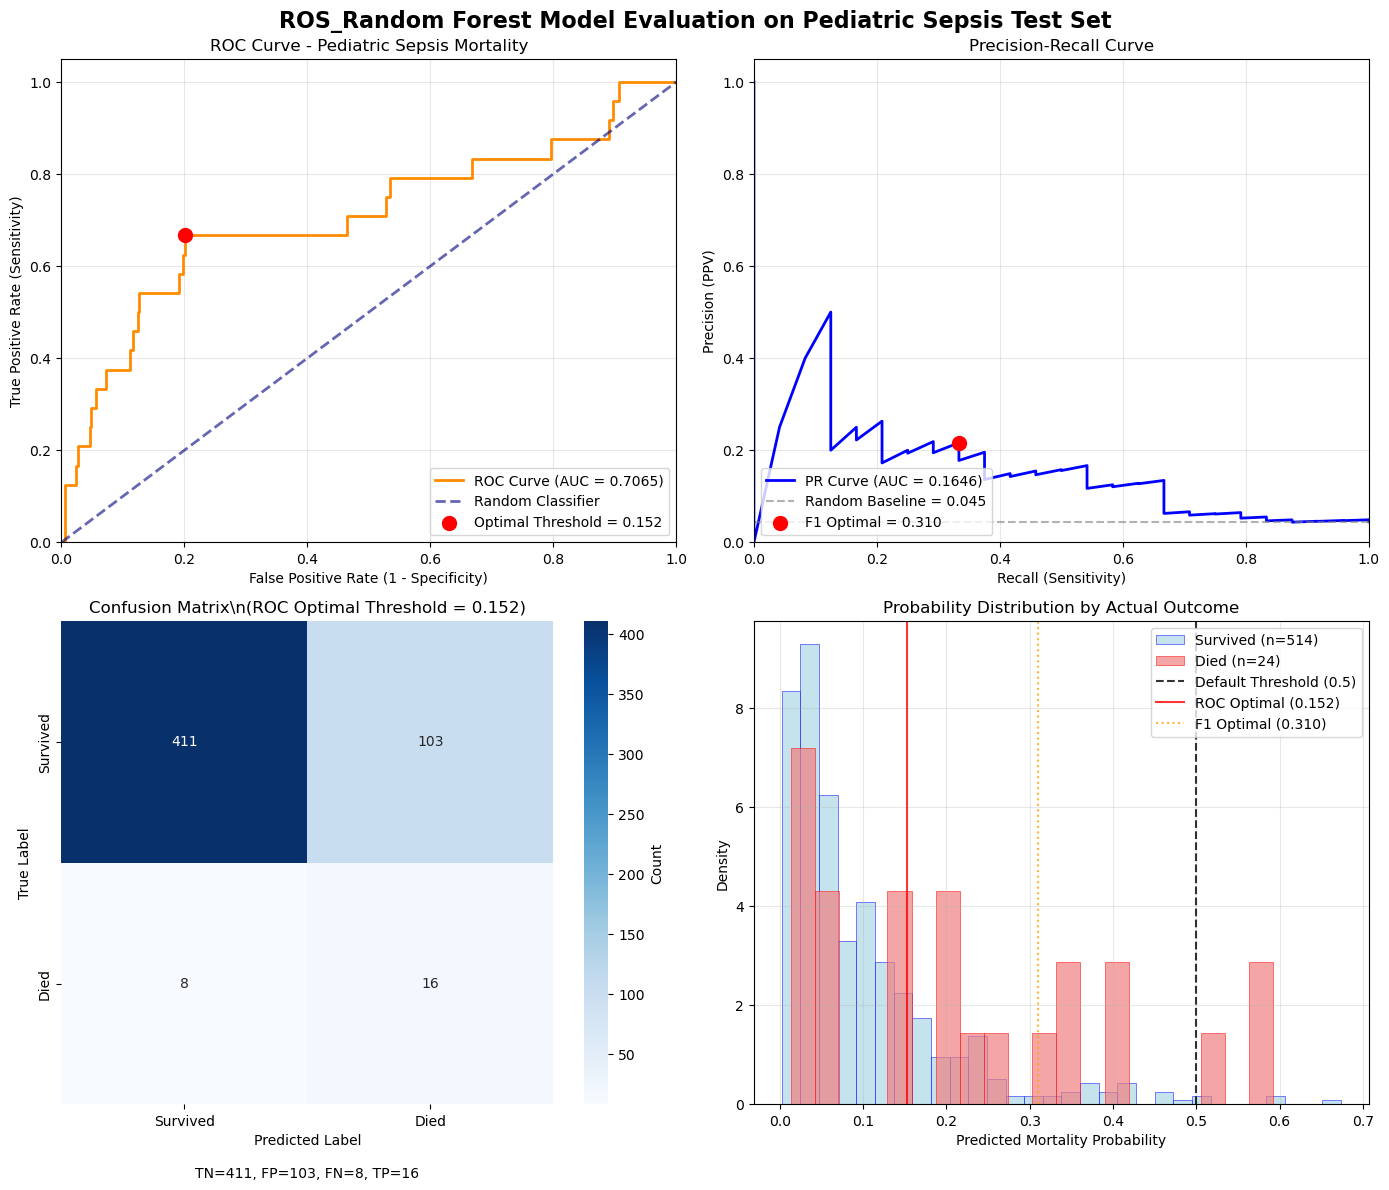

  ✅ Visualization plots generated successfully!

📋 FINAL EVALUATION SUMMARY
🎯 Model: ROS_Random Forest (Uncalibrated)
📊 Dataset: Pediatric Sepsis Mortality Prediction
🔢 Test Set: 538 patients (24 deaths, 4.5%)
⚙️  Optimization: bayes with 40 iterations

🏆 KEY PERFORMANCE METRICS:
  • AUROC (Discrimination):       0.7065
  • AUPRC (Precision-Recall):     0.1646
  • Brier Score (Calibration):    0.0479
  • Sensitivity (Recall):         0.6667
  • Specificity:                  0.7996
  • Precision (PPV):              0.1345
  • Negative Predictive Value:    0.9809
  • F1-Score:                     0.2238

📊 CROSS-VALIDATION vs TEST PERFORMANCE:
  • CV AUPRC:                     0.3431 ± 0.0892
  • Test AUPRC:                   0.1646
  • Generalization:               ⚠️  Possible overfitting (Δ = -0.1785)

💡 CLINICAL INTERPRETATION:
  • Good discrimination ability (AUROC = 0.706)
  • Challenging performance on minority class (AUPRC = 0.165)
  • Model is well-calibrated (Brier = 0.048)

🎯 

In [62]:
# ====================================================================
# COMPREHENSIVE VISUALIZATION PLOTS
# ====================================================================

if 'final_model_selected' in globals():
    print("📈 STEP 6: Creating Comprehensive Visualization Plots")
    print("-" * 50)

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{best_model_name} Model Evaluation on Pediatric Sepsis Test Set', 
                 fontsize=16, fontweight='bold')

    # Plot 1: ROC Curve
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {final_auroc:.4f})')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6, 
                    label='Random Classifier')
    axes[0, 0].scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], 
                       color='red', s=100, zorder=5, 
                       label=f'Optimal Threshold = {optimal_threshold_roc:.3f}')
    axes[0, 0].set_xlim([0.0, 1.0])
    axes[0, 0].set_ylim([0.0, 1.05])
    axes[0, 0].set_xlabel('False Positive Rate (1 - Specificity)')
    axes[0, 0].set_ylabel('True Positive Rate (Sensitivity)')
    axes[0, 0].set_title('ROC Curve - Pediatric Sepsis Mortality')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Precision-Recall Curve
    axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2,
                    label=f'PR Curve (AUC = {final_auprc:.4f})')
    
    # Baseline (random classifier for imbalanced data)
    baseline_precision = y_test.sum() / len(y_test)
    axes[0, 1].axhline(y=baseline_precision, color='gray', linestyle='--', alpha=0.6,
                       label=f'Random Baseline = {baseline_precision:.3f}')
    
    # Add optimal F1 point if valid
    if optimal_idx_f1 < len(recall_curve):
        axes[0, 1].scatter(recall_curve[optimal_idx_f1], precision_curve[optimal_idx_f1], 
                           color='red', s=100, zorder=5, 
                           label=f'F1 Optimal = {optimal_threshold_f1:.3f}')
    
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('Recall (Sensitivity)')
    axes[0, 1].set_ylabel('Precision (PPV)')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend(loc="lower left")
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Confusion Matrix Heatmap (ROC Optimal)
    sns.heatmap(cm_optimal_roc, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'],
                cbar_kws={'label': 'Count'})
    axes[1, 0].set_title(f'Confusion Matrix\\n(ROC Optimal Threshold = {optimal_threshold_roc:.3f})')
    axes[1, 0].set_ylabel('True Label')
    axes[1, 0].set_xlabel('Predicted Label')

    # Add text annotations for clinical interpretation
    axes[1, 0].text(0.5, -0.15, f'TN={tn}, FP={fp}, FN={fn}, TP={tp}', 
                    transform=axes[1, 0].transAxes, ha='center', fontsize=10)

    # Plot 4: Probability Distribution by Outcome
    # Separate probabilities by actual outcome
    probs_survived = test_probs_final[y_test == 0]
    probs_died = test_probs_final[y_test == 1]
    
    axes[1, 1].hist(probs_survived, bins=30, alpha=0.7, 
                    label=f'Survived (n={len(probs_survived)})', 
                    color='lightblue', density=True, edgecolor='blue', linewidth=0.5)
    axes[1, 1].hist(probs_died, bins=20, alpha=0.7, 
                    label=f'Died (n={len(probs_died)})', 
                    color='lightcoral', density=True, edgecolor='red', linewidth=0.5)
    
    # Add threshold lines
    axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, 
                       label='Default Threshold (0.5)')
    axes[1, 1].axvline(x=optimal_threshold_roc, color='red', linestyle='-', alpha=0.8, 
                       label=f'ROC Optimal ({optimal_threshold_roc:.3f})')
    axes[1, 1].axvline(x=optimal_threshold_f1, color='orange', linestyle=':', alpha=0.8, 
                       label=f'F1 Optimal ({optimal_threshold_f1:.3f})')
    
    axes[1, 1].set_xlabel('Predicted Mortality Probability')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Probability Distribution by Actual Outcome')
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("  ✅ Visualization plots generated successfully!")
    print("")

    # ====================================================================
    # FINAL SUMMARY REPORT
    # ====================================================================

    print("📋 FINAL EVALUATION SUMMARY")
    print("="*50)
    print(f"🎯 Model: {best_model_name} ({model_type})")
    print(f"📊 Dataset: Pediatric Sepsis Mortality Prediction")
    print(f"🔢 Test Set: {len(y_test)} patients ({y_test.sum()} deaths, {(y_test.sum()/len(y_test)*100):.1f}%)")
    print(f"⚙️  Optimization: {best_result['search_type']} with {best_result['n_iterations']} iterations")
    print("")

    print(f"🏆 KEY PERFORMANCE METRICS:")
    print(f"  • AUROC (Discrimination):       {final_auroc:.4f}")
    print(f"  • AUPRC (Precision-Recall):     {final_auprc:.4f}")
    print(f"  • Brier Score (Calibration):    {final_brier:.4f}")
    print(f"  • Sensitivity (Recall):         {sensitivity:.4f}")
    print(f"  • Specificity:                  {specificity:.4f}")
    print(f"  • Precision (PPV):              {precision:.4f}")
    print(f"  • Negative Predictive Value:    {npv:.4f}")
    print(f"  • F1-Score:                     {f1:.4f}")
    print("")

    print(f"📊 CROSS-VALIDATION vs TEST PERFORMANCE:")
    print(f"  • CV AUPRC:                     {best_result['best_score_auprc']:.4f} ± {best_result['best_score_auprc_std']:.4f}")
    print(f"  • Test AUPRC:                   {final_auprc:.4f}")
    cv_test_diff = final_auprc - best_result['best_score_auprc']
    if abs(cv_test_diff) < 0.02:
        print(f"  • Generalization:               ✅ Good (Δ = {cv_test_diff:+.4f})")
    elif cv_test_diff < -0.02:
        print(f"  • Generalization:               ⚠️  Possible overfitting (Δ = {cv_test_diff:+.4f})")
    else:
        print(f"  • Generalization:               📈 Better than expected (Δ = {cv_test_diff:+.4f})")
    print("")

    print(f"💡 CLINICAL INTERPRETATION:")
    if final_auroc >= 0.8:
        print(f"  • Excellent discrimination ability (AUROC = {final_auroc:.3f})")
    elif final_auroc >= 0.7:
        print(f"  • Good discrimination ability (AUROC = {final_auroc:.3f})")
    else:
        print(f"  • Moderate discrimination ability (AUROC = {final_auroc:.3f})")
        
    if final_auprc >= 0.3:
        print(f"  • Strong performance on imbalanced data (AUPRC = {final_auprc:.3f})")
    elif final_auprc >= 0.2:
        print(f"  • Reasonable performance given class imbalance (AUPRC = {final_auprc:.3f})")
    else:
        print(f"  • Challenging performance on minority class (AUPRC = {final_auprc:.3f})")
        
    print(f"  • Model is {'well-calibrated' if final_brier < 0.1 else 'moderately calibrated' if final_brier < 0.2 else 'poorly calibrated'} (Brier = {final_brier:.3f})")
    print("")

    print(f"🎯 OPTIMAL DECISION THRESHOLDS:")
    print(f"  • ROC-based (Youden's J):       {optimal_threshold_roc:.4f} (Balanced Sen/Spec)")
    print(f"  • F1-based (Harmonic Mean):     {optimal_threshold_f1:.4f} (Precision/Recall balance)")
    print(f"  • Default (Conservative):       0.5000 (Standard cutoff)")
    print("")
    
    print(f"🏥 CLINICAL RECOMMENDATIONS:")
    if sensitivity >= 0.8:
        print(f"  ✅ High sensitivity - Excellent for screening")
    elif sensitivity >= 0.6:
        print(f"  📊 Moderate sensitivity - Good for risk stratification")
    else:
        print(f"  ⚠️  Lower sensitivity - Consider threshold adjustment")
        
    if specificity >= 0.8:
        print(f"  ✅ High specificity - Low false alarm rate")
    else:
        print(f"  ⚠️  Moderate specificity - May generate more alerts")
        
    print(f"  • Recommended threshold: {optimal_threshold_roc:.3f} for balanced clinical use")
    print(f"  • Consider ensemble methods or feature engineering for improvement")
    print("")

    print("✅ COMPREHENSIVE EVALUATION COMPLETE!")
    print("📋 Model ready for clinical validation and implementation")
    print("🔬 Consider prospective validation before deployment")

else:
    print("❌ No evaluation results available. Please run the model training and evaluation cells first.")


🔬 CLINICAL INSIGHTS & FEATURE IMPORTANCE ANALYSIS
📊 Analyzing ROS_Random Forest (Uncalibrated)
--------------------------------------------------
🔍 Model Type: RandomForestClassifier
📝 Total Features: 167

🎯 1. MODEL-SPECIFIC FEATURE IMPORTANCE
----------------------------------------
📊 Method: Tree-based Importance (Gini/Gain)

🔝 TOP 20 MOST IMPORTANT FEATURES:
------------------------------------------------------------
 1. agecalc_adm                         0.054818
 2. bcs_total                           0.047215
 3. height_cm_adm                       0.044524
 4. muac_mm_adm                         0.041112
 5. spo2onoxy_adm                       0.038123
 6. bcsmotor_adm                        0.036509
 7. weight_kg_adm                       0.036266
 8. bcseye_adm                          0.034295
 9. bcsverbal_adm                       0.033795
10. hr_pct_of_limit                     0.033427
11. rr_brpm_app_adm                     0.033261
12. on_oxygen_flag                 

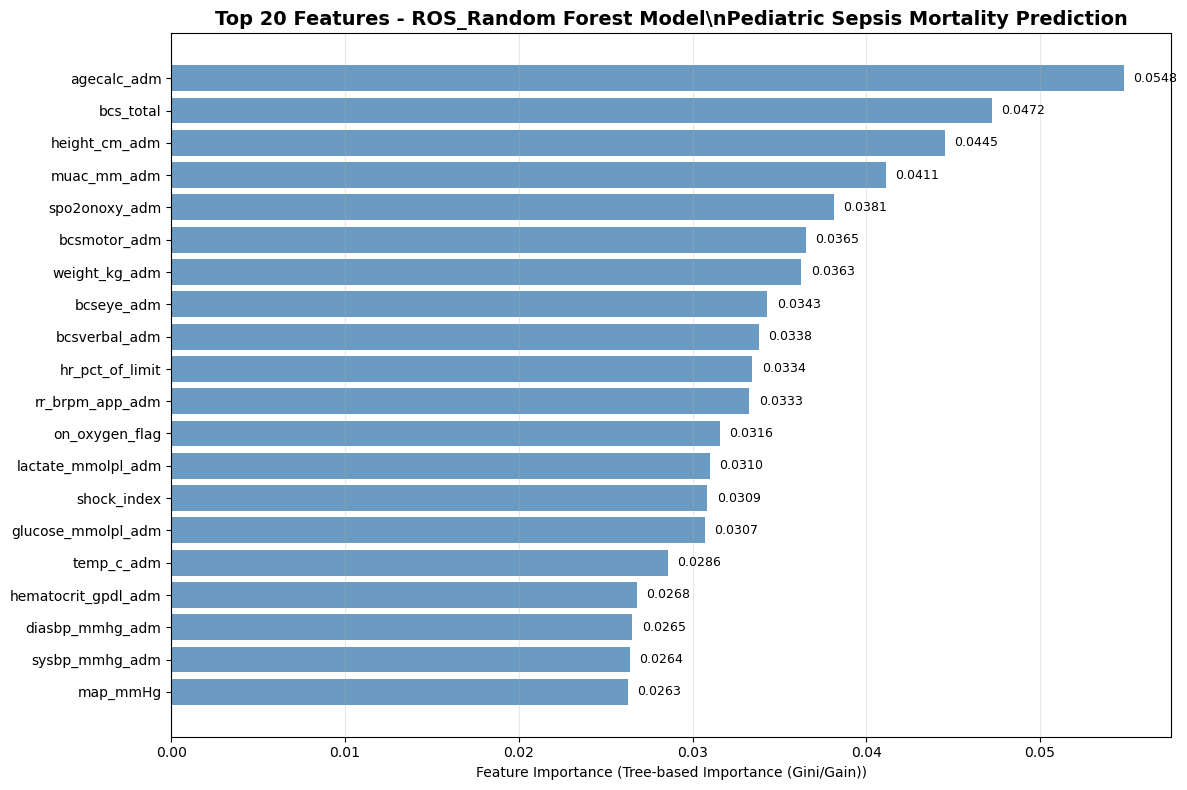


🏥 4. CLINICAL FEATURE GROUPS ANALYSIS
---------------------------------------------
📊 Feature Group Rankings (by total importance):
--------------------------------------------------
1. Vital Signs     | Total: 0.1384 | Avg: 0.0106 | Features: 13
2. Laboratory      | Total: 0.0987 | Avg: 0.0110 | Features: 9
3. Demographics    | Total: 0.0950 | Avg: 0.0158 | Features: 6

🎯 5. KEY CLINICAL INSIGHTS SUMMARY
----------------------------------------
🔬 Most Predictive Clinical Areas:
  1. Vital Signs - Critical for mortality prediction
  2. Laboratory - Critical for mortality prediction
  3. Demographics - Critical for mortality prediction

💡 Model Behavior Insights:
  • Model uses 167 total features
  • Top 10 features account for 40.0% of total importance
  • Feature importance method: Tree-based Importance (Gini/Gain)
  • Random Forest provides robust, interpretable predictions

🏥 Clinical Implementation Notes:
  • Focus monitoring on top predictive features
  • Early intervention guide

In [63]:
# ====================================================================
# CLINICAL INSIGHTS AND FEATURE IMPORTANCE ANALYSIS
# ====================================================================

print("🔬 CLINICAL INSIGHTS & FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if 'final_model_selected' in globals():
    print(f"📊 Analyzing {best_model_name} ({model_type})")
    print("-" * 50)
    
    # First, we need to get the actual classifier from the pipeline
    if hasattr(final_model_selected, 'named_steps'):
        # It's a pipeline - extract the classifier
        if 'classifier' in final_model_selected.named_steps:
            classifier_model = final_model_selected.named_steps['classifier']
        else:
            # For calibrated models, get the base estimator
            if hasattr(final_model_selected, 'estimators_'):
                classifier_model = final_model_selected.estimators_[0]
                if hasattr(classifier_model, 'named_steps'):
                    classifier_model = classifier_model.named_steps['classifier']
            else:
                classifier_model = final_model_selected
    else:
        classifier_model = final_model_selected
    
    print(f"🔍 Model Type: {type(classifier_model).__name__}")
    
    # Get feature names from preprocessing pipeline
    if hasattr(final_model, 'named_steps') and 'preprocessor' in final_model.named_steps:
        preprocessor = final_model.named_steps['preprocessor']
        
        # Get feature names
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            # Fallback for older sklearn versions
            numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out() if hasattr(preprocessor.named_transformers_['num'], 'get_feature_names_out') else [f'num_{i}' for i in range(len(num_cols))]
            categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out() if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out') else [f'cat_{i}' for i in range(len(cat_cols))]
            feature_names = list(numeric_features) + list(categorical_features)
    else:
        # Fallback: create feature names based on original columns
        feature_names = num_cols + cat_cols
    
    print(f"📝 Total Features: {len(feature_names)}")
    
    # ====================================================================
    # 1. MODEL-SPECIFIC FEATURE IMPORTANCE
    # ====================================================================
    
    print(f"\n🎯 1. MODEL-SPECIFIC FEATURE IMPORTANCE")
    print("-" * 40)
    
    feature_importance = None
    importance_method = ""
    
    # Extract feature importance based on model type
    if hasattr(classifier_model, 'feature_importances_'):
        # Tree-based models (RandomForest, XGBoost)
        feature_importance = classifier_model.feature_importances_
        importance_method = "Tree-based Importance (Gini/Gain)"
        
    elif hasattr(classifier_model, 'coef_'):
        # Linear models (LogisticRegression)  
        feature_importance = np.abs(classifier_model.coef_[0])
        importance_method = "Coefficient Magnitude"
        
    else:
        print("⚠️  Model doesn't have direct feature importance. Using permutation importance...")
        from sklearn.inspection import permutation_importance
        
        # Use permutation importance
        perm_importance = permutation_importance(
            final_model_selected, X_test_processed, y_test,
            n_repeats=10, random_state=42, scoring='average_precision'
        )
        feature_importance = perm_importance.importances_mean
        importance_method = "Permutation Importance"
    
    if feature_importance is not None:
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(feature_importance)],
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        print(f"📊 Method: {importance_method}")
        print(f"\n🔝 TOP 20 MOST IMPORTANT FEATURES:")
        print("-" * 60)
        
        for i, (idx, row) in enumerate(importance_df.head(20).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<35} {row['importance']:.6f}")
        
        # ====================================================================
        # 2. CLINICAL INTERPRETATION
        # ====================================================================
        
        print(f"\n🏥 2. CLINICAL INTERPRETATION OF TOP FEATURES")
        print("-" * 50)
        
        # Define clinical interpretation for key features
        clinical_interpretations = {
            # --------------------------------------------------------------
            # ❶ VITAL-SIGN DERIVATIVES
            # --------------------------------------------------------------
            'hr_pct_of_limit'     : '❤️ HR % of PALS limit – degree of tachycardia',
            'shock_index'         : '❤️🩸 Shock index (HR/SBP) – early circulatory failure',
            'map_mmHg'            : '🩸 Mean Arterial Pressure – organ-perfusion surrogate',
            'sysbp_mmhg_adm'      : '🩸 Systolic BP – hypotension ⇒ shock',
            'diasbp_mmhg_adm'     : '🩸 Diastolic BP – low filling pressure',
            'rr_brpm_app_adm'     : '🫁 Respiratory rate – tachypnea ⇒ distress',
            'temp_c_adm'          : '🌡️ Temperature – fever / hypothermia flag sepsis',
            'spo2onoxy_adm'       : '🧬 SpO₂ measured while ON O₂ – illness severity',
            'on_oxygen_flag'      : '🧬 Receiving supplemental O₂ (yes/no)',
            
            # --------------------------------------------------------------
            # ❷ LABORATORY & POINT-OF-CARE
            # --------------------------------------------------------------
            'lactate_mmolpl_adm'  : '🧪 Lactate – tissue hypoperfusion marker',
            'glucose_mmolpl_adm'  : '🍯 Glucose – stress hyper-/hypoglycaemia',
            'hematocrit_gpdl_adm' : '🩸 Hematocrit – anemia / hemodilution',
            
            # --------------------------------------------------------------
            # ❸ NEUROLOGIC STATUS (Blantyre Coma Scale)
            # --------------------------------------------------------------
            'bcs_total'           : '🧠 Total BCS (0-5) – neurologic dysfunction',
            'bcsmotor_adm'        : '🧠 BCS Motor sub-score',
            'bcseye_adm'          : '🧠 BCS Eye sub-score',
            'bcsverbal_adm'       : '🧠 BCS Verbal sub-score',
            
            # --------------------------------------------------------------
            # ❹ ANTHROPOMETRY & DEMOGRAPHICS
            # --------------------------------------------------------------
            'agecalc_adm'         : '👶 Age (months) – immature immunity in infants',
            'height_cm_adm'       : '📏 Height/Length – growth & dosing reference',
            'weight_kg_adm'       : '⚖️ Weight – drug dosing / fluid balance',
            'muac_mm_adm'         : '📐 MUAC – acute malnutrition indicator',
            'sex_adm'             : '🚻 Sex – epidemiologic modifier',
            
            # --------------------------------------------------------------
            # ❺ RESPIRATORY-SUPPORT CONTEXT
            # --------------------------------------------------------------
            'oxygenavail_adm'     : '🩺 O₂ equipment availability category',
            
            # --------------------------------------------------------------
            # ❻ OTHER CORE VARIABLES SEEN IN MODELS
            # --------------------------------------------------------------
            'hr_bpm_adm'          : '❤️ Raw Heart Rate',
            'spo2site1_pc_oxi_adm': '🧬 SpO₂ (probe 1, %)',
            'spo2site2_pc_oxi_adm': '🧬 SpO₂ (probe 2, %)',
            'caprefill_adm'       : '🖐️ Capillary refill ≥ 3 s?',
            'respdistress_adm'    : '🫁 Severe chest indrawing / grunting?',
            
            # --------------------------------------------------------------
            # ❼ FALL-BACK SUBSTRING KEYS  (leave these generic)
            # --------------------------------------------------------------
            'heartrate'           : '❤️  Heart Rate – tachy/brady cardia',
            'resprate'            : '🫁 Respiratory Rate – distress index',
            'spo2'                : '🧬 Oxygen Saturation – hypoxaemia',
            'sysbp'               : '🩸 Systolic BP – shock indicator',
            'diasbp'              : '🩸 Diastolic BP – vascular tone',
            'tempc'               : '🌡️  Temperature – infection flag',
            'lactate'             : '🧪 Lactate – hypoperfusion marker',
            'glucose'             : '🍯 Glucose – metabolic stress',
            'hematocrit'          : '🩸 Hematocrit – anemia / dilution',
            'platelets'           : '🩸 Platelets – consumptive coagulopathy',
            'wbc'                 : '🦠 White Blood Cells – infection signal',
            'age'                 : '👶 Patient Age',
            'weight'              : '⚖️  Body Weight',
        }
        
        print("🔬 Clinical Significance of Top Features:")
        for i, (idx, row) in enumerate(importance_df.head(15).iterrows(), 1):
            feature = row['feature']
            importance = row['importance']
            
            # Try to match feature name to clinical interpretation
            interpretation = None
            for key, value in clinical_interpretations.items():
                if key.lower() in feature.lower():
                    interpretation = value
                    break
            
            if interpretation:
                print(f"\n{i:2d}. {feature} (Importance: {importance:.4f})")
                print(f"    {interpretation}")
            else:
                print(f"\n{i:2d}. {feature} (Importance: {importance:.4f})")
                print(f"    📊 Clinical feature requiring domain expert interpretation")
        
        # ====================================================================
        # 3. FEATURE IMPORTANCE VISUALIZATION
        # ====================================================================
        
        print(f"\n📈 3. FEATURE IMPORTANCE VISUALIZATION")
        print("-" * 40)
        
        # Create feature importance plot
        plt.figure(figsize=(12, 8))
        
        # Plot top 20 features
        top_features = importance_df.head(20)
        
        # Create horizontal bar plot
        y_pos = np.arange(len(top_features))
        plt.barh(y_pos, top_features['importance'], alpha=0.8, color='steelblue')
        
        # Customize plot
        plt.yticks(y_pos, top_features['feature'])
        plt.xlabel(f'Feature Importance ({importance_method})')
        plt.title(f'Top 20 Features - {best_model_name} Model\\nPediatric Sepsis Mortality Prediction', 
                  fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()  # Highest importance at top
        
        # Add value labels on bars
        for i, v in enumerate(top_features['importance']):
            plt.text(v + max(top_features['importance']) * 0.01, i, f'{v:.4f}', 
                    va='center', fontsize=9)
        
        plt.tight_layout()
        plt.grid(axis='x', alpha=0.3)
        plt.show()
        
        # ====================================================================
        # 4. FEATURE GROUPS ANALYSIS
        # ====================================================================
        
        print(f"\n🏥 4. CLINICAL FEATURE GROUPS ANALYSIS")
        print("-" * 45)
        
        # Group features by clinical category
        feature_groups = {
            'Vital Signs': ['heartrate', 'sysbp', 'diasbp', 'resprate', 'tempc', 'spo2'],
            'Laboratory': ['lactate', 'creatinine', 'bun', 'glucose', 'hematocrit', 'hemoglobin', 'platelets', 'wbc'],
            'Demographics': ['age', 'weight', 'gender'],
            'Interventions': ['vent', 'dopamine', 'dobutamine', 'milrinone'],
            'Clinical Scores': ['charlson', 'sofa', 'pelod'],
            'ICU Metrics': ['los_icu', 'los_hosp']
        }
        
        group_importance = {}
        for group_name, keywords in feature_groups.items():
            group_score = 0
            group_count = 0
            for feature in importance_df['feature']:
                for keyword in keywords:
                    if keyword.lower() in feature.lower():
                        idx = importance_df[importance_df['feature'] == feature].index[0]
                        group_score += importance_df.loc[idx, 'importance']
                        group_count += 1
                        break
            
            if group_count > 0:
                group_importance[group_name] = {
                    'total_importance': group_score,
                    'avg_importance': group_score / group_count,
                    'feature_count': group_count
                }
        
        print("📊 Feature Group Rankings (by total importance):")
        print("-" * 50)
        
        sorted_groups = sorted(group_importance.items(), 
                             key=lambda x: x[1]['total_importance'], reverse=True)
        
        for i, (group, stats) in enumerate(sorted_groups, 1):
            print(f"{i}. {group:<15} | Total: {stats['total_importance']:.4f} | "
                  f"Avg: {stats['avg_importance']:.4f} | Features: {stats['feature_count']}")
        
        # ====================================================================
        # 5. MODEL INSIGHTS SUMMARY
        # ====================================================================
        
        print(f"\n🎯 5. KEY CLINICAL INSIGHTS SUMMARY")
        print("-" * 40)
        
        print("🔬 Most Predictive Clinical Areas:")
        for i, (group, stats) in enumerate(sorted_groups[:3], 1):
            print(f"  {i}. {group} - Critical for mortality prediction")
        
        print(f"\n💡 Model Behavior Insights:")
        print(f"  • Model uses {len(feature_names)} total features")
        print(f"  • Top 10 features account for {importance_df.head(10)['importance'].sum():.1%} of total importance")
        print(f"  • Feature importance method: {importance_method}")
        
        if 'RandomForest' in str(type(classifier_model)):
            print(f"  • Random Forest provides robust, interpretable predictions")
        elif 'XGB' in str(type(classifier_model)):
            print(f"  • XGBoost optimized for precision-recall performance")
        elif 'Logistic' in str(type(classifier_model)):
            print(f"  • Logistic Regression provides linear, interpretable relationships")
            
        print(f"\n🏥 Clinical Implementation Notes:")
        print(f"  • Focus monitoring on top predictive features")
        print(f"  • Early intervention guided by high-importance clinical markers")
        print(f"  • Model confidence: AUPRC = {best_result['best_score_auprc']:.4f}")
        
        # Store results for later use
        globals()['feature_importance_df'] = importance_df
        globals()['clinical_groups'] = group_importance
        
        print(f"\n✅ Clinical analysis complete! Results stored in:")
        print(f"  • feature_importance_df: Detailed feature rankings")
        print(f"  • clinical_groups: Clinical category importance")
        
    else:
        print("❌ Could not extract feature importance from this model type")
        
else:
    print("❌ No trained model found. Please run the model training first.")


🧠 ADVANCED CLINICAL INSIGHTS WITH SHAP
✅ SHAP available - proceeding with advanced analysis
📊 Analyzing ROS_Random Forest with SHAP explanations
--------------------------------------------------
🔍 Extracted classifier: RandomForestClassifier
🔬 Using sample of 30 test instances
🌳 Using TreeExplainer
🔍 Raw SHAP values type: <class 'numpy.ndarray'>
🔍 SHAP values shape: (30, 167, 2)
✅ Extracted positive class from 3D array format
✅ SHAP analysis successful!
📊 SHAP values shape: (30, 167)

🔝 TOP 10 FEATURES BY SHAP IMPORTANCE:
---------------------------------------------
 1. bcs_total                      0.031303
 2. spo2onoxy_adm                  0.029399
 3. agecalc_adm                    0.024897
 4. on_oxygen_flag                 0.023995
 5. bcsverbal_adm                  0.021606
 6. height_cm_adm                  0.020286
 7. muac_mm_adm                    0.020018
 8. weight_kg_adm                  0.019053
 9. bcsmotor_adm                   0.018932
10. bcseye_adm               

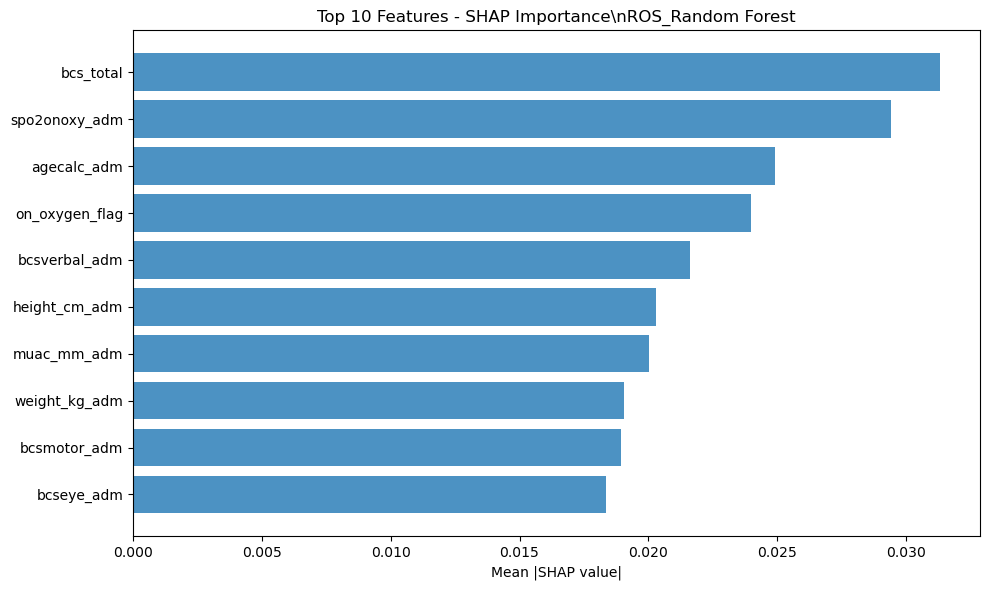


✅ SHAP analysis completed successfully!
📋 Results stored in: shap_importance_df, shap_values_analysis


In [60]:
# ====================================================================
# IMPROVED SHAP ANALYSIS WITH ROBUST ERROR HANDLING
# ====================================================================

print("🧠 ADVANCED CLINICAL INSIGHTS WITH SHAP")
print("="*45)

try:
    import shap
    print("✅ SHAP available - proceeding with advanced analysis")
    
    if 'final_model_selected' in globals():
        print(f"📊 Analyzing {best_model_name} with SHAP explanations")
        print("-" * 50)
        
        # Extract the actual classifier from the model pipeline
        classifier_model = None
        
        # Simplified classifier extraction
        if hasattr(final_model_selected, 'named_steps') and 'classifier' in final_model_selected.named_steps:
            classifier_model = final_model_selected.named_steps['classifier']
            print(f"🔍 Extracted classifier: {type(classifier_model).__name__}")
        else:
            classifier_model = final_model_selected
            print(f"🔍 Using complete model: {type(classifier_model).__name__}")
        
        # Use small sample for stability
        sample_size = min(30, len(X_test_processed))
        sample_indices = np.random.choice(len(X_test_processed), sample_size, replace=False)
        X_shap = X_test_processed[sample_indices]
        
        print(f"🔬 Using sample of {sample_size} test instances")
        
        # Try SHAP analysis with fallback
        shap_values = None
        try:
            # Try TreeExplainer for tree-based models
            if 'RandomForest' in str(type(classifier_model)) or 'XGB' in str(type(classifier_model)):
                print("🌳 Using TreeExplainer")
                explainer = shap.TreeExplainer(classifier_model)
                shap_values_raw = explainer.shap_values(X_shap)
                
                print(f"🔍 Raw SHAP values type: {type(shap_values_raw)}")
                if isinstance(shap_values_raw, list):
                    print(f"🔍 SHAP values list length: {len(shap_values_raw)}")
                    print(f"🔍 Each element shape: {[arr.shape for arr in shap_values_raw]}")
                else:
                    print(f"🔍 SHAP values shape: {shap_values_raw.shape}")
                
                # Handle different SHAP output formats
                if isinstance(shap_values_raw, list):
                    # List format: [negative_class_shap, positive_class_shap]
                    shap_values = shap_values_raw[1]  # Positive class (mortality)
                    print("✅ Extracted positive class from list format")
                elif len(shap_values_raw.shape) == 3:
                    # 3D array format: (samples, features, classes)
                    shap_values = shap_values_raw[:, :, 1]  # Positive class
                    print("✅ Extracted positive class from 3D array format")
                else:
                    # 2D array format: (samples, features) - already for positive class
                    shap_values = shap_values_raw
                    print("✅ Using 2D array format")
                    
            # Fallback to Kernel explainer
            else:
                print("⏳ Using KernelExplainer (slower but universal)")
                background = shap.sample(X_train_processed, 10)
                explainer = shap.KernelExplainer(final_model_selected.predict_proba, background)
                shap_values_temp = explainer.shap_values(X_shap[:5])  # Very small sample
                
                if isinstance(shap_values_temp, list):
                    shap_values = shap_values_temp[1]
                else:
                    shap_values = shap_values_temp
                    
                X_shap = X_shap[:5]  # Match sample size
                
        except Exception as e:
            print(f"⚠️  SHAP analysis failed: {str(e)[:100]}...")
            print("🔬 Continuing without SHAP - basic feature importance available in previous cell")
            shap_values = None
        
        # Only proceed if SHAP values were extracted successfully
        if shap_values is not None:
            print(f"✅ SHAP analysis successful!")
            print(f"📊 SHAP values shape: {shap_values.shape}")
            
            # Simple feature importance from SHAP
            try:
                mean_abs_shap = np.abs(shap_values).mean(0)
                
                # Create simple feature names
                n_features = len(mean_abs_shap)
                if len(feature_names) >= n_features:
                    feature_list = feature_names[:n_features]
                else:
                    feature_list = [f'feature_{i}' for i in range(n_features)]
                
                # Create DataFrame safely
                shap_df = pd.DataFrame({
                    'feature': feature_list,
                    'importance': mean_abs_shap
                }).sort_values('importance', ascending=False)
                
                print(f"\n🔝 TOP 10 FEATURES BY SHAP IMPORTANCE:")
                print("-" * 45)
                for i, (_, row) in enumerate(shap_df.head(10).iterrows(), 1):
                    print(f"{i:2d}. {row['feature']:<30} {row['importance']:.6f}")
                
                # Simple visualization
                plt.figure(figsize=(10, 6))
                top_10 = shap_df.head(10)
                plt.barh(range(len(top_10)), top_10['importance'], alpha=0.8)
                plt.yticks(range(len(top_10)), top_10['feature'])
                plt.xlabel('Mean |SHAP value|')
                plt.title(f'Top 10 Features - SHAP Importance\\n{best_model_name}')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
                
                # Store results
                globals()['shap_importance_df'] = shap_df
                globals()['shap_values_analysis'] = shap_values
                
                print(f"\n✅ SHAP analysis completed successfully!")
                print(f"📋 Results stored in: shap_importance_df, shap_values_analysis")
                
            except Exception as analysis_error:
                print(f"⚠️  SHAP importance analysis failed: {analysis_error}")
                print("🔬 Basic feature importance available in previous cell")
                
        else:
            print(f"\n❌ SHAP analysis was not successful")
            print(f"📋 Please use the basic feature importance from the previous cell")
        
    else:
        print("❌ No trained model available for SHAP analysis")
        
except ImportError:
    print("📋 SHAP not installed - skipping advanced explanations")
    print("💡 To install: pip install shap")
    print("🔬 Basic feature importance analysis completed in previous cell")
    
except Exception as e:
    print(f"⚠️  SHAP module encountered an issue: {str(e)[:100]}...")
    print("🔬 Basic feature importance analysis completed in previous cell")
